In [2]:
!pip install pyGPGO
!pip install --pre -U matplotlib

  Using cached https://files.pythonhosted.org/packages/8d/87/a113c91ba014708114f7635d5c0f6a5e5c773480c5f0a537b257a02d180d/pyGPGO-0.4.0.dev1.tar.gz
  Using cached https://files.pythonhosted.org/packages/7d/c4/6341148ad458b6cd8361b774d7ee6895c38eab88f05331f22304c484ed5d/Theano-1.0.4.tar.gz
  Using cached https://files.pythonhosted.org/packages/32/19/6c94cbadb287745ac38ff1197b9fadd66500b6b9c468e79099b110c6a2e9/pymc3-3.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/8b/83472d660e004a69b8e7b3c1dd12a607167774097138445d0dda1a3590dc/arviz-0.6.1-py3-none-any.whl
     |████████████████████████████████| 634kB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d8/5b/3098db49a61ccc8583ffead6aedc226f08ff56dc03106b6ec54451e27a30/packaging-20.0-py2.py3-none-any.whl
     |██████████████████████████

# Redifine \_firstRun method of the class GPGO to allow custom initial configuration

In [1]:
def myFirstRun(self, init_rand_configs=None, n_eval=3):
    """
    Performs initial evaluations before fitting GP.

    Parameters
    ----------
    init_rand_configs: list
        Initial random configurations
    n_eval: int
        Number of initial evaluations to perform. Default is 3.

    """
    if init_rand_configs is None:
      self.X = np.empty((n_eval, len(self.parameter_key)))
      self.y = np.empty((n_eval,))
      for i in range(n_eval):
          s_param = self._sampleParam()
          s_param_val = list(s_param.values())
          self.X[i] = s_param_val
          self.y[i] = self.f(**s_param)
    else:
      self.X = np.empty((len(init_rand_configs),len(init_rand_configs[0])))
      self.y = np.empty((len(init_rand_configs),))
      self.init_evals = len(self.y)
      for i in range(len(init_rand_configs)):
        self.X[i] = list(init_rand_configs[i].values())
        self.y[i] = self.f(**init_rand_configs[i])
    self.GP.fit(self.X, self.y)
    self.tau = np.max(self.y)
    if init_rand_configs is None: 
      self.history.append([init_rand_configs[np.argmax(self.y)], self.tau])
    else:
      idx_max_param = np.argmax(self.y)
      self.history.append([{key: self.X[idx_max_param, idx] for idx, key in enumerate(self.parameter_key)}, self.GP.y[-1], self.tau])

# Override updateGP method of the class GPGO to allow saves also for the acquired points

In [2]:
def myUpdateGP(self):
  """
  Updates the internal model with the next acquired point and its evaluation.
  """
  kw = {param: int(self.best[i]) if self.parameter_type[i] == 'int' else float(self.best[i])
        for i, param in enumerate(self.parameter_key)}
  f_new = self.f(**kw)
  self.GP.update(np.atleast_2d(self.best), np.atleast_1d(f_new))
  self.tau = np.max(self.GP.y)
  self.history.append([kw, self.GP.y[-1], self.tau])

# AUTOML

AUTOml for our model

### Define fitness function

In [3]:
import keras.optimizers
from dataset import get_data, get_wdc_data
from fitness import fit
import utils
import json
from utils import get_pretrained_embedding

Using TensorFlow backend.


In [4]:
import gc
gc.collect()

27

In [5]:
config = {
    'train_path' : './dataset/computers/train/computers_splitted_train_medium.json',
    'valid_path' : './dataset/computers/valid/computers_splitted_valid_medium.json',
    'test_path' : "./dataset/computers/test/computers_gs.json",
    'EXP_DIR' : 'data/exps/exp15',
    'PRETRAINED_EMBEDDING_PATH' : './dataset/embeddings/fasttext/fasttext_title_300Epochs_1MinCount_9ContextWindow_100d.txt',
    'NUM_WORDS' : None,
    'MAX_LEN': 20,
    'BATCH_SIZE' : 32,
    'EMBEDDING_DIM' : 100,
    'RNN_UNITS' : 100,
    'EARLY_STOPPING' : 10,
    'EPOCHS' : 20,
    'TRAINABLE':False
}

In [6]:
def get_fitness_for_automl(config):
  train_gen, val_gen, test_gen, class_weights = get_wdc_data(
            config['train_path'],
            config['valid_path'],
            config['test_path'],
            word_index_path="dataset/title_word_index.json",
            num_words=config['NUM_WORDS'],
            max_len=config['MAX_LEN'],
            batch_size=config['BATCH_SIZE'],
            preprocess_data=True,
            preprocess_method="nltk",
        )
  word_index = json.loads(open("dataset/title_word_index.json").read())
  NUM_WORDS = len(word_index) if config['NUM_WORDS'] is None else NUM_WORDS
  print("* NUM WORDS: ", NUM_WORDS)
  print("* CLASS WEIGHTS:", class_weights)

  embedding_matrix = None
  if config['PRETRAINED_EMBEDDING_PATH'] is not None:
      embedding_matrix = get_pretrained_embedding(
          config['PRETRAINED_EMBEDDING_PATH'], NUM_WORDS + 1, 
          config['EMBEDDING_DIM'], word_index
      )

  def fitness(
      lr=0.001,
      embedding_dim=150,
      embedding_dropout=0.3, 
      rnn_units=100,
      convs_filter_banks=4,
      convs_kernel_size=2,
      pool_size=2,
      denses_depth=3,
      mlp_dropout=0.3,  
      optimizer_type='adam', 
      similarity_type=0):
    
    optimizer = getattr(keras.optimizers, optimizer_type)(lr=lr)
    matrix_similarity_function = getattr(utils, 'dot_similarity' if similarity_type == 0 else 'cosine_similarity')
    model, results = fit(
        train_gen,
        val_gen,
        NUM_WORDS,
        config['EMBEDDING_DIM'],
        config['MAX_LEN'],
        matrix_similarity_function,
        config['EXP_DIR'],
        config['EARLY_STOPPING'],
        denses_depth=denses_depth,
        activation="sigmoid",
        embedding_matrix=embedding_matrix,
        embedding_trainable=config['TRAINABLE'],
        embedding_dropout=embedding_dropout,
        rnn_type="LSTM",
        rnn_units=rnn_units,
        convs_filter_banks=convs_filter_banks,
        convs_kernel_size=convs_kernel_size,
        pool_size=pool_size,
        mlp_dropout=mlp_dropout,
        epochs=config['EPOCHS'],
        verbosity=1,
        callbacks=False,
        class_weights=None,
        optimizer=None
    )
    return results[3]
  return fitness

### ExpectedImprovement

In [7]:
import numpy as np
import functools

from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D 
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
    
furtherEvaluations = 10
# param = {'lr': ('cont', [0.01,0.1]),'momentum': ('cont', [0.1,0.9])} 
 
param = {
    'lr': ('cont', [0.000001, 1.0]),
    'rnn_units': ('int', [50, 150]),
    'similarity_type': ('int', [0, 1]),
    'convs_filter_banks': ('int', [4, 64]),
    'convs_kernel_size': ('int', [2, 4]),
    'pool_size': ('int', [2, 4]),
    'denses_depth': ('int', [1, 6]),
} 

init_rand_configs = [{
    'lr':0.0001,
    'rnn_units':100,
    'similarity_type': 1,
    'convs_filter_banks':32,
    'convs_kernel_size':3,
    'pool_size':2,
    'denses_depth':3,
}] 

# creating a GP surrogate model with a Squared Exponantial covariance function,
# aka kernel
sexp = squaredExponential()
sur_model = GaussianProcess(sexp)
fitness = get_fitness_for_automl(config)
# setting the acquisition function
acq = Acquisition(mode="ExpectedImprovement")

# creating an object Bayesian Optimization
bo_step1_expected = GPGO(sur_model,acq,fitness,param,n_jobs=1)
bo_step1_expected._firstRun = functools.partial(myFirstRun, bo_step1_expected)
bo_step1_expected.updateGP = functools.partial(myUpdateGP, bo_step1_expected)
bo_step1_expected._firstRun(init_rand_configs=init_rand_configs)
bo_step1_expected.logger._printInit(bo_step1_expected)

* PREPROCESS DATA
* DONE
* FOUND 4362 unique vocabs
* PREPROCESS DATA
* DONE
* FOUND 3444 unique vocabs
* PREPROCESS DATA
* DONE
* FOUND 2791 unique vocabs
* NUM WORDS:  4764
* CLASS WEIGHTS: [0.63919052 2.29609929]
* LOADING EMBEDDINGS MATRIX
* FOUND 4764 WORD VECTORS
* FOUND 4764 vector representations out of 4765 words
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embeddi

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 100)      476500      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 20, 100)      0           embedding_2[0][0]          

Epoch 1/20
202/202 [==============================] - 17s 83ms/step - loss: 0.5668 - accuracy: 0.7540 - val_loss: 0.6813 - val_accuracy: 0.7788
Epoch 2/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5469 - accuracy: 0.7748 - val_loss: 0.6954 - val_accuracy: 0.7825
Epoch 3/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5390 - accuracy: 0.7795 - val_loss: 0.7162 - val_accuracy: 0.7825
Epoch 4/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5347 - accuracy: 0.7794 - val_loss: 0.7251 - val_accuracy: 0.7812
Epoch 5/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5290 - accuracy: 0.7822 - val_loss: 0.7786 - val_accuracy: 0.7819
Epoch 6/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5188 - accuracy: 0.7822 - val_loss: 0.7151 - val_accuracy: 0.7700
Epoch 7/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5086 - accuracy: 0.7822 - val_loss: 0.7112 - val_accuracy:

Epoch 4/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5487 - accuracy: 0.7754 - val_loss: 0.7985 - val_accuracy: 0.7831
Epoch 5/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5384 - accuracy: 0.7795 - val_loss: 0.7814 - val_accuracy: 0.7831
Epoch 6/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5408 - accuracy: 0.7791 - val_loss: 0.7906 - val_accuracy: 0.7831
Epoch 7/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5349 - accuracy: 0.7803 - val_loss: 0.7716 - val_accuracy: 0.7831
Epoch 8/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5283 - accuracy: 0.7789 - val_loss: 0.7724 - val_accuracy: 0.7831
Epoch 9/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5184 - accuracy: 0.7809 - val_loss: 0.7745 - val_accuracy: 0.7831
Epoch 10/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5069 - accuracy: 0.7817 - val_loss: 0.7929 - val_accuracy

202/202 [==============================] - 14s 67ms/step - loss: 0.5203 - accuracy: 0.7808 - val_loss: 0.7926 - val_accuracy: 0.7825
Epoch 10/20
202/202 [==============================] - 13s 67ms/step - loss: 0.5124 - accuracy: 0.7806 - val_loss: 0.7632 - val_accuracy: 0.7719
Epoch 11/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4971 - accuracy: 0.7817 - val_loss: 0.7613 - val_accuracy: 0.7812
Epoch 12/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4909 - accuracy: 0.7791 - val_loss: 0.7369 - val_accuracy: 0.7744
Epoch 13/20
202/202 [==============================] - 13s 67ms/step - loss: 0.4768 - accuracy: 0.7916 - val_loss: 0.7241 - val_accuracy: 0.7731
Epoch 14/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4593 - accuracy: 0.7942 - val_loss: 0.6489 - val_accuracy: 0.7719
Epoch 15/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4476 - accuracy: 0.7986 - val_loss: 0.5685 - val_accuracy: 0.70

202/202 [==============================] - 15s 72ms/step - loss: 0.5480 - accuracy: 0.7803 - val_loss: 0.7006 - val_accuracy: 0.7831
Epoch 7/20
202/202 [==============================] - 15s 72ms/step - loss: 0.5439 - accuracy: 0.7806 - val_loss: 0.7266 - val_accuracy: 0.7831
Epoch 8/20
202/202 [==============================] - 15s 72ms/step - loss: 0.5398 - accuracy: 0.7803 - val_loss: 0.7141 - val_accuracy: 0.7831
Epoch 9/20
202/202 [==============================] - 15s 72ms/step - loss: 0.5360 - accuracy: 0.7811 - val_loss: 0.7142 - val_accuracy: 0.7831
Epoch 10/20
202/202 [==============================] - 14s 72ms/step - loss: 0.5404 - accuracy: 0.7820 - val_loss: 0.7019 - val_accuracy: 0.7831
Epoch 11/20
202/202 [==============================] - 15s 72ms/step - loss: 0.5322 - accuracy: 0.7814 - val_loss: 0.7107 - val_accuracy: 0.7831
Epoch 12/20
202/202 [==============================] - 14s 72ms/step - loss: 0.5293 - accuracy: 0.7816 - val_loss: 0.7450 - val_accuracy: 0.7831


/home/belerico/.local/share/virtualenvs/aml-project-EQl709OG/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* FINAL EVALUATION [0.783125, 0.6132847656249999, 0.783125, 0.6878763582194181]
5      	 [  0.2079302 107.          0.         35.          2.          3.
   5.       ]. 	  0.6878763582194181 	 0.7689285575942596
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 20, 100)      476500      input_13[0][0]                   
                                                                 input_14[0][

Epoch 1/20
202/202 [==============================] - 17s 84ms/step - loss: 0.6812 - accuracy: 0.6012 - val_loss: 0.6851 - val_accuracy: 0.7819
Epoch 2/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5921 - accuracy: 0.7324 - val_loss: 0.7078 - val_accuracy: 0.7831
Epoch 3/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5802 - accuracy: 0.7420 - val_loss: 0.7396 - val_accuracy: 0.7831
Epoch 4/20
202/202 [==============================] - 14s 68ms/step - loss: 0.5686 - accuracy: 0.7579 - val_loss: 0.7073 - val_accuracy: 0.7831
Epoch 5/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5545 - accuracy: 0.7681 - val_loss: 0.7515 - val_accuracy: 0.7831
Epoch 6/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5472 - accuracy: 0.7698 - val_loss: 0.7723 - val_accuracy: 0.7831
Epoch 7/20
202/202 [==============================] - 14s 67ms/step - loss: 0.5480 - accuracy: 0.7749 - val_loss: 0.7618 - val_accuracy:

Epoch 1/20
202/202 [==============================] - 18s 88ms/step - loss: 0.6163 - accuracy: 0.6878 - val_loss: 0.6900 - val_accuracy: 0.7831
Epoch 2/20
202/202 [==============================] - 14s 69ms/step - loss: 0.5734 - accuracy: 0.7618 - val_loss: 0.6932 - val_accuracy: 0.7831
Epoch 3/20
202/202 [==============================] - 14s 70ms/step - loss: 0.5717 - accuracy: 0.7717 - val_loss: 0.7237 - val_accuracy: 0.7831
Epoch 4/20
202/202 [==============================] - 14s 70ms/step - loss: 0.5560 - accuracy: 0.7789 - val_loss: 0.7461 - val_accuracy: 0.7831
Epoch 5/20
202/202 [==============================] - 14s 70ms/step - loss: 0.5487 - accuracy: 0.7812 - val_loss: 0.7606 - val_accuracy: 0.7831
Epoch 6/20
202/202 [==============================] - 14s 70ms/step - loss: 0.5429 - accuracy: 0.7797 - val_loss: 0.7550 - val_accuracy: 0.7831
Epoch 7/20
202/202 [==============================] - 14s 70ms/step - loss: 0.5316 - accuracy: 0.7822 - val_loss: 0.7409 - val_accuracy:

202/202 [==============================] - 14s 67ms/step - loss: 0.5139 - accuracy: 0.7834 - val_loss: 0.7412 - val_accuracy: 0.7825
Epoch 7/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4982 - accuracy: 0.7830 - val_loss: 0.6802 - val_accuracy: 0.7806
Epoch 8/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4809 - accuracy: 0.7856 - val_loss: 0.7148 - val_accuracy: 0.7956
Epoch 9/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4559 - accuracy: 0.8021 - val_loss: 0.6625 - val_accuracy: 0.7656
Epoch 10/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4334 - accuracy: 0.8077 - val_loss: 0.6172 - val_accuracy: 0.7638
Epoch 11/20
202/202 [==============================] - 14s 67ms/step - loss: 0.4098 - accuracy: 0.8222 - val_loss: 0.6314 - val_accuracy: 0.7900
Epoch 12/20
202/202 [==============================] - 14s 68ms/step - loss: 0.3885 - accuracy: 0.8311 - val_loss: 0.6052 - val_accuracy: 0.7656


Epoch 9/20
202/202 [==============================] - 14s 68ms/step - loss: 0.5200 - accuracy: 0.7795 - val_loss: 0.6928 - val_accuracy: 0.7825
Epoch 10/20
202/202 [==============================] - 14s 68ms/step - loss: 0.5178 - accuracy: 0.7826 - val_loss: 0.7609 - val_accuracy: 0.7831
Epoch 11/20
202/202 [==============================] - 14s 68ms/step - loss: 0.5048 - accuracy: 0.7830 - val_loss: 0.6915 - val_accuracy: 0.7837
Epoch 12/20
202/202 [==============================] - 14s 68ms/step - loss: 0.4963 - accuracy: 0.7811 - val_loss: 0.6724 - val_accuracy: 0.7844
Epoch 13/20
202/202 [==============================] - 14s 68ms/step - loss: 0.4866 - accuracy: 0.7840 - val_loss: 0.6835 - val_accuracy: 0.7869
Epoch 14/20
202/202 [==============================] - 14s 68ms/step - loss: 0.4755 - accuracy: 0.7894 - val_loss: 0.6365 - val_accuracy: 0.7794
Epoch 15/20
202/202 [==============================] - 14s 68ms/step - loss: 0.4694 - accuracy: 0.7927 - val_loss: 0.6178 - val_acc

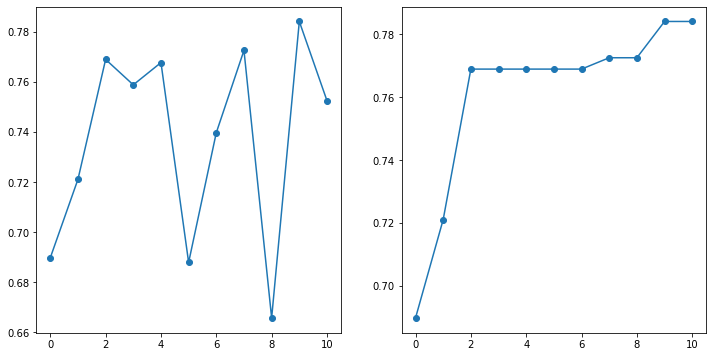

In [8]:
bo_step1_expected.run(furtherEvaluations, resume=True)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot([val[1] for val in bo_step1_expected.history], marker="o")
plt.subplot(1, 2, 2)
plt.plot([val[2] for val in bo_step1_expected.history], marker="o")

In [16]:
import pickle
with open('exp100embedding_fastte.pickle', 'wb') as handle:
    pickle.dump(bo_step1_expected.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
bo_step1_expected.history

[[{'lr': 0.0001,
   'rnn_units': 100.0,
   'similarity_type': 1.0,
   'convs_filter_banks': 32.0,
   'convs_kernel_size': 3.0,
   'pool_size': 2.0,
   'denses_depth': 3.0},
  0.7023447194224692,
  0.7023447194224692],
 [{'lr': 0.26501134412903393,
   'rnn_units': 100,
   'similarity_type': 0,
   'convs_filter_banks': 32,
   'convs_kernel_size': 2,
   'pool_size': 2,
   'denses_depth': 3},
  0.6861631883549631,
  0.7023447194224692],
 [{'lr': 0.274334136670901,
   'rnn_units': 99,
   'similarity_type': 0,
   'convs_filter_banks': 32,
   'convs_kernel_size': 2,
   'pool_size': 2,
   'denses_depth': 3},
  0.6861631883549631,
  0.7023447194224692],
 [{'lr': 0.44863852667513643,
   'rnn_units': 94,
   'similarity_type': 0,
   'convs_filter_banks': 34,
   'convs_kernel_size': 3,
   'pool_size': 2,
   'denses_depth': 5},
  0.6861631883549631,
  0.7023447194224692],
 [{'lr': 0.4577958272115615,
   'rnn_units': 94,
   'similarity_type': 0,
   'convs_filter_banks': 32,
   'convs_kernel_size': 2,

#### Plot selected points during run


KeyError: 'momentum'

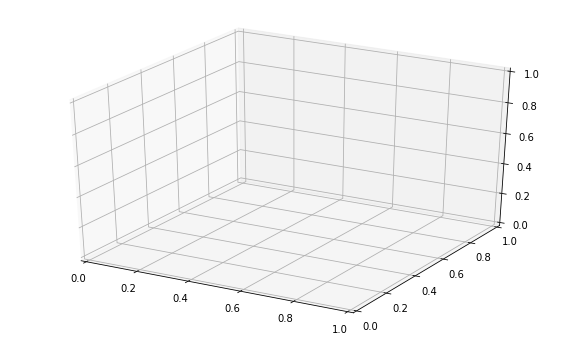

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

x = [val[0]['lr'] for val in bo_step1_expected.history]
y = [val[0]['momentum'] for val in bo_step1_expected.history]
z = [val[1] for val in bo_step1_expected.history]

img = ax.scatter(x, y, z, c=z, marker="o", cmap="coolwarm", depthshade=True)
plt.colorbar(img)
ax.set_xlabel('Learning rate',labelpad=10)
ax.set_ylabel('Momentum',labelpad=10)
ax.set_zlabel('Accuracy',labelpad=10)
ax.dist = 13

#### Plot best seen points during run

KeyError: ignored

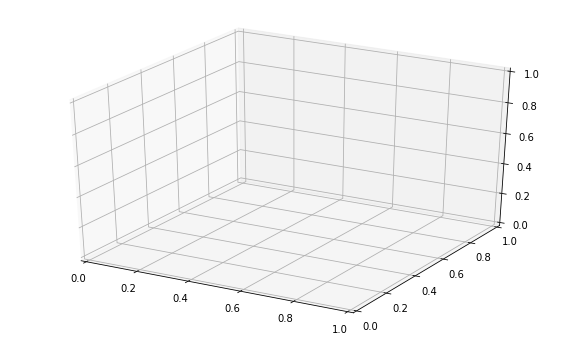

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

x = [val[0]['lr'] for val in bo_step1_expected.history]
y = [val[0]['momentum'] for val in bo_step1_expected.history]
z = [val[2] for val in bo_step1_expected.history]

img = ax.scatter(x, y, z, c=z, marker="o", cmap="coolwarm")
plt.colorbar(img,)
ax.set_xlabel('Learning rate',labelpad=10)
ax.set_ylabel('Momentum',labelpad=10)
ax.set_zlabel('Accuracy',labelpad=10)
ax.dist = 13